In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# own utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.tram_data_helpers import *
from scipy.special import logit

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "tramdagpaper_exp6_1_linearDGP_cs_new"   ## <--- set experiment name
seed=42

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs_new/configuration.json


# 2.  Data

- same experiment as in https://arxiv.org/pdf/2503.16206 6.1 Conitnous Case
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

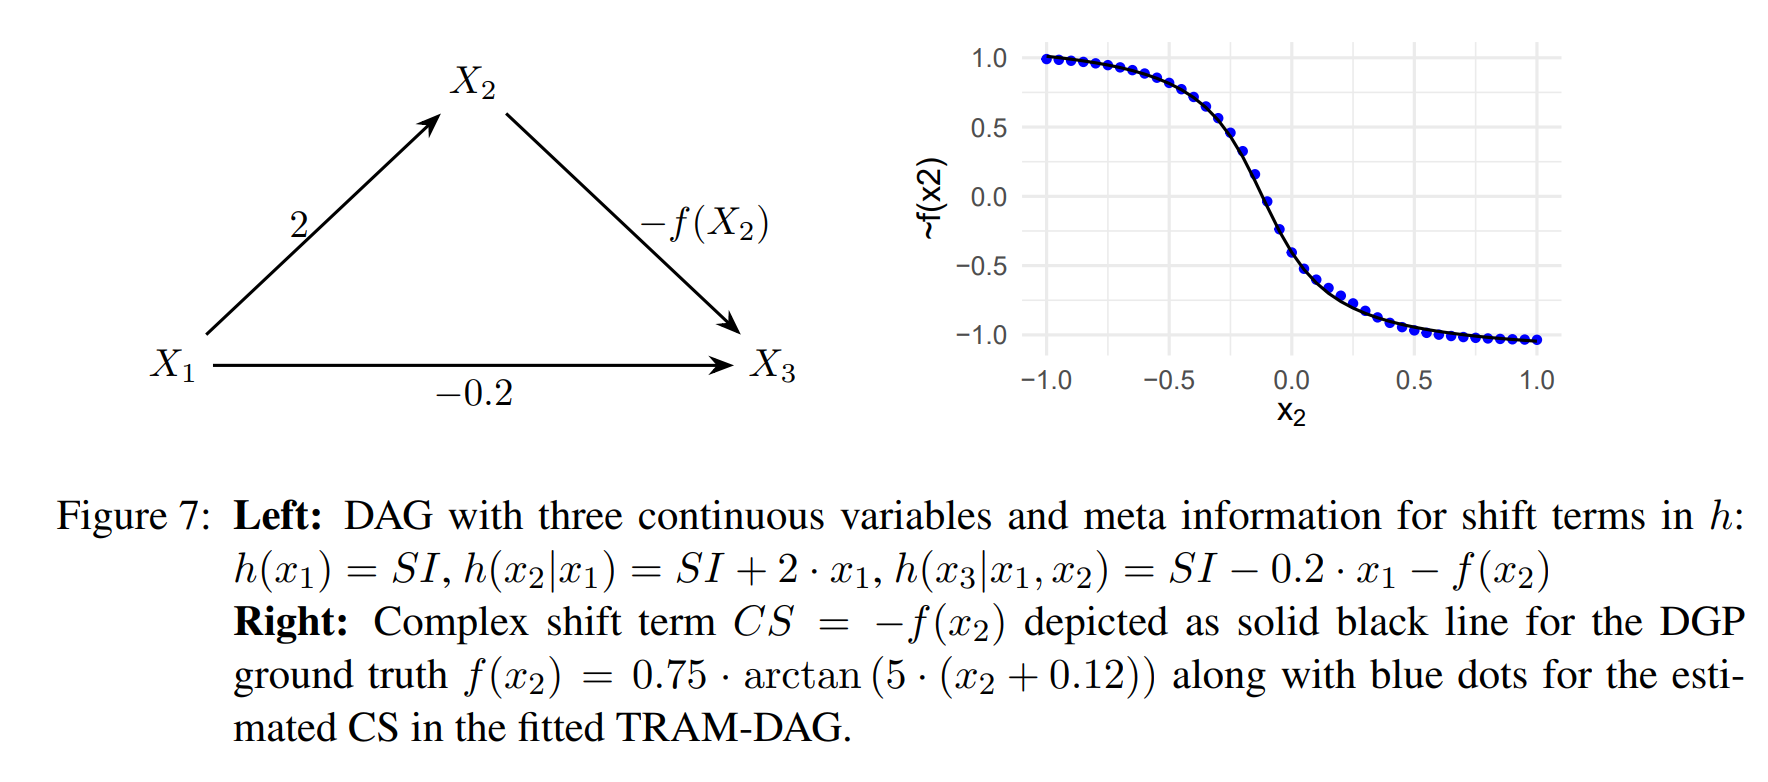

they made 3 experiments:
1. Linear-shift DGP and linear-shift model 
2. Complex-shift DGP and complex-shift model  
3. Linear-shift DGP and complex-shift model <------------------

Setting Seed: 42
Setting Seed: 42
         x1        x2        x3
0  0.299671 -0.274509 -0.546968
1  0.236174  0.463615  0.823753
2  0.314769 -0.265411 -1.262545
3  0.699038  0.013699 -1.134076
4  0.226585 -0.117170 -2.032878
Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as a continuous variable. for target and predictor.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB


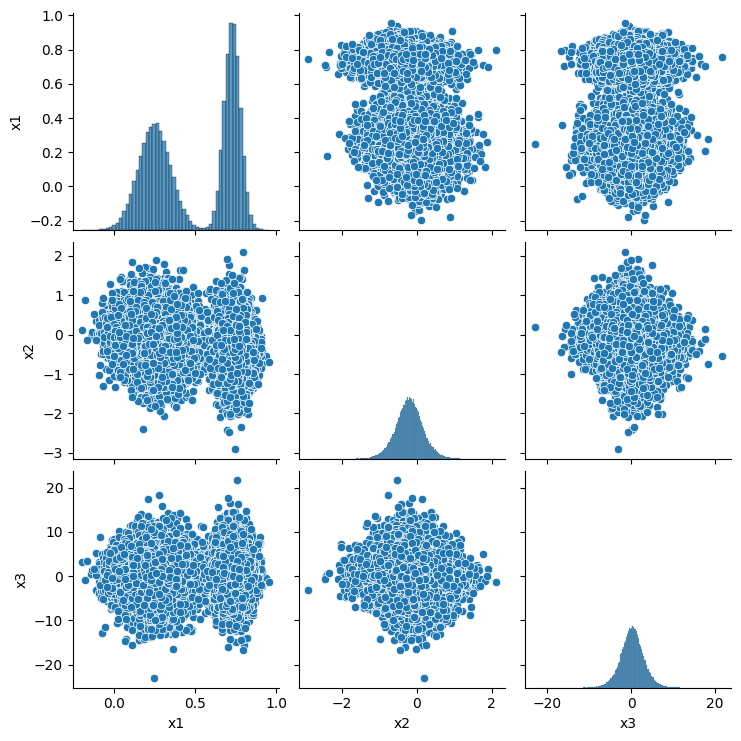

In [3]:
# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return -0.3*x  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = logit(u2)
        x2 = (z2 - 2 * x1) / 5#5#   0.42  in the trainagle strucutred cont last line is 5 for SI
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 -f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          - f(X2)        | replace h(x2|x1) with z
    # z3          = 0.63*x3 + beta3 * x1          - f(X2)        | reformulate to x2
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z3+0.2 * x1   +f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        z3 = logit(u3)
        x3 = (z3 + 0.2 * x1 + f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])
        
    #df = pd.DataFrame({'x1': x1, 'x2': x2})#, 'x3': x3})
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

n_obs=10_000

df = dgp(n_obs=n_obs, seed=42)

EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")

if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=100000, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

data_type= {'x1':'continous','x2':'continous','x3':'continous'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

## 2.1 train test split

In [4]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

train_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_train.csv"), index=False)
val_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_val.csv"), index=False)
test_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_test.csv"), index=False)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")



Train size: 80000, Validation size: 10000, Test size: 10000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

No matrix found. Please fill out the DAG and click 'Generate'.


# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************


In [7]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12157964485414742, 'max': 0.794303998711493, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8069206639187695, 'max': 0.418925659248077, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'continous', 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('cs')}, 'min': -4.4354394138675595, 'max': 4.9162449184293, '

In [8]:
# hyperparams:
train_list=['x1','x2','x3']#<-  set the nodes which have to be trained , useful if further training is required else lsit all vars
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
# if you change the hyperparams -> write them to the config file!

In [ ]:
# For each NODE 
node_list = configuration_dict['nodes'] 

for node in node_list:
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    ########################## 0. Get hyperparameters ###############################
    # batch_size, epochs, learning_rate, use_scheduler = get_hyperparameters_for_node(node,node_list)
    
    ############ Edited hyperparameters ##########
    batch_size = 512
    epochs = 500
    learning_rate = 0.01
    use_scheduler = False
    ###########################################
    
    print(f"Using hyperparameters: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, use_scheduler={use_scheduler}\n")
    
    ########################## 1. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (node_list[node]['node_type'] == 'source') and (node_list[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 2. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    

    ########################## 3. Check if training is complete ###############################
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 4. Create Model ##############################
    
    tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=True, set_initial_weights=True)
    
    ########################## 5. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, node_list, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, debug=False)

    ########################## 6. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                node_list,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=True,
                verbose=1,
                device=device,
                debug=False) # TODO startvalues for bernsteinpols




----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Using hyperparameters: batch_size=512, epochs=500, learning_rate=0.01, use_scheduler=False

[DEBUG] R script written to: /tmp/tmp2ae6pbvw.R
[DEBUG] R code:
 
library(MASS)
library(tram)
library(readr)

data <- read_csv("/home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs_new/tramdagpaper_exp6_1_linearDGP_cs_new_train.csv")
model <- Colr(x1 ~ 1, data=data, order=19)
cat(model$theta, sep="\n")

[DEBUG] Rscript succeeded
[DEBUG] STDOUT:
 -2.246133
-1.745155
-1.057427
-1.057427
-0.7017669
-0.2315873
-0.04547494
-0.04547492
-0.04547491
-0.04547489
-0.04547488
-0.04547486
-0.04547485
-0.04547483
-0.04547482
-0.0454748
-0.04547479
0.3690576
1.216967
2.239766

[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
No existing model found. Starting fresh...


/home/bule/TramDag/utils/tram_model_helpers.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 1.6186  Val NLL: 1.1862  [Train: 2.66s  Val: 0.37s  Total: 3.03s]
Saved new best model.
Epoch 2/500  Train NLL: 0.9134  Val NLL: 0.6692  [Train: 1.99s  Val: 0.32s  Total: 2.32s]
Saved new best model.
Epoch 3/500  Train NLL: 0.5178  Val NLL: 0.3728  [Train: 2.22s  Val: 0.37s  Total: 2.60s]
Saved new best model.
Epoch 4/500  Train NLL: 0.2814  Val NLL: 0.1848  [Train: 2.21s  Val: 0.35s  Total: 2.57s]
Saved new best model.
Epoch 5/500  Train NLL: 0.1240  Val NLL: 0.0539  [Train: 1.98s  Val: 0.37s  Total: 2.35s]
Saved new best model.
Epoch 6/500  Train NLL: 0.0106  Val NLL: -0.0435  [Train: 1.72s  Val: 0.34s  Total: 2.06s]
Saved new best model.
Epoch 7/500  Train NLL: -0.0760  Val NLL: -0.1195  [Train: 2.28s  Val: 0.34s  Total: 2.62s]
Saved new best model.
Epoch 8/500  Train NLL: -0.1440  Val NLL: -0.1807  [Train: 2.33s  Val: 0.34s  Total: 2.68s]
Saved new best model.
Epoch 9/500  Train NLL: -0.1996  Val NLL: -0.2313  [Train: 2.21s  Val: 0.35s 

# 6 Inspect Training

## 6.1 Loss vs epochs

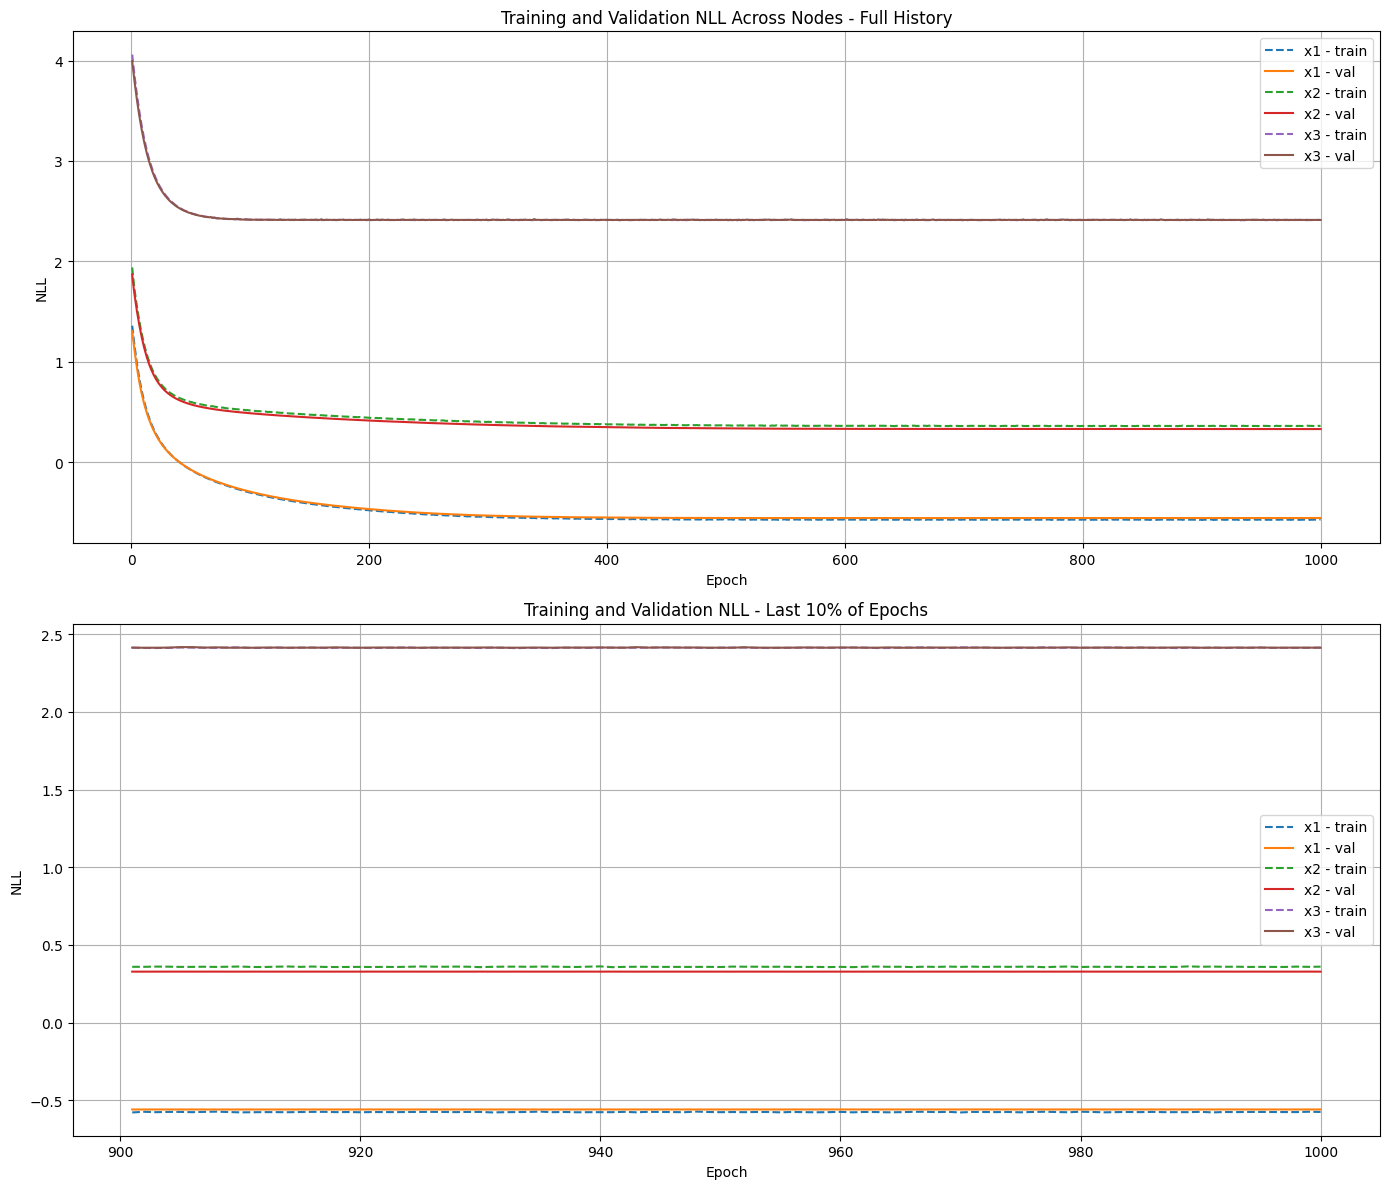

In [ ]:
show_training_history(node_list,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]

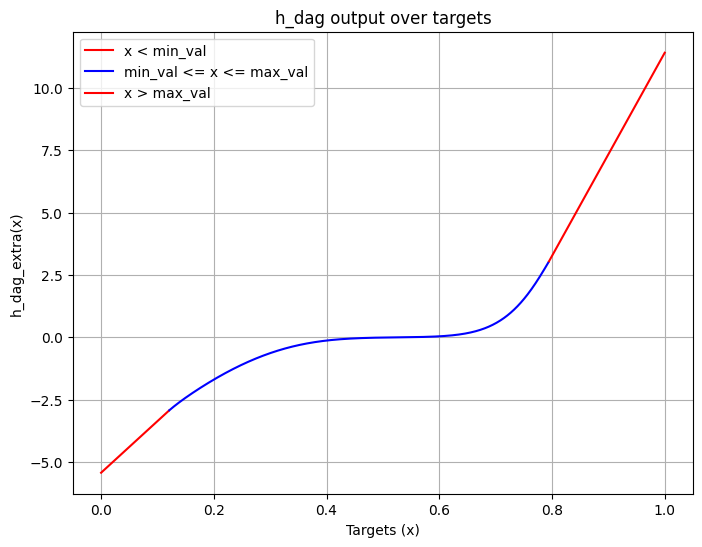


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [ ]:
show_hdag_for_source_nodes(configuration_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


Val loader (x1): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


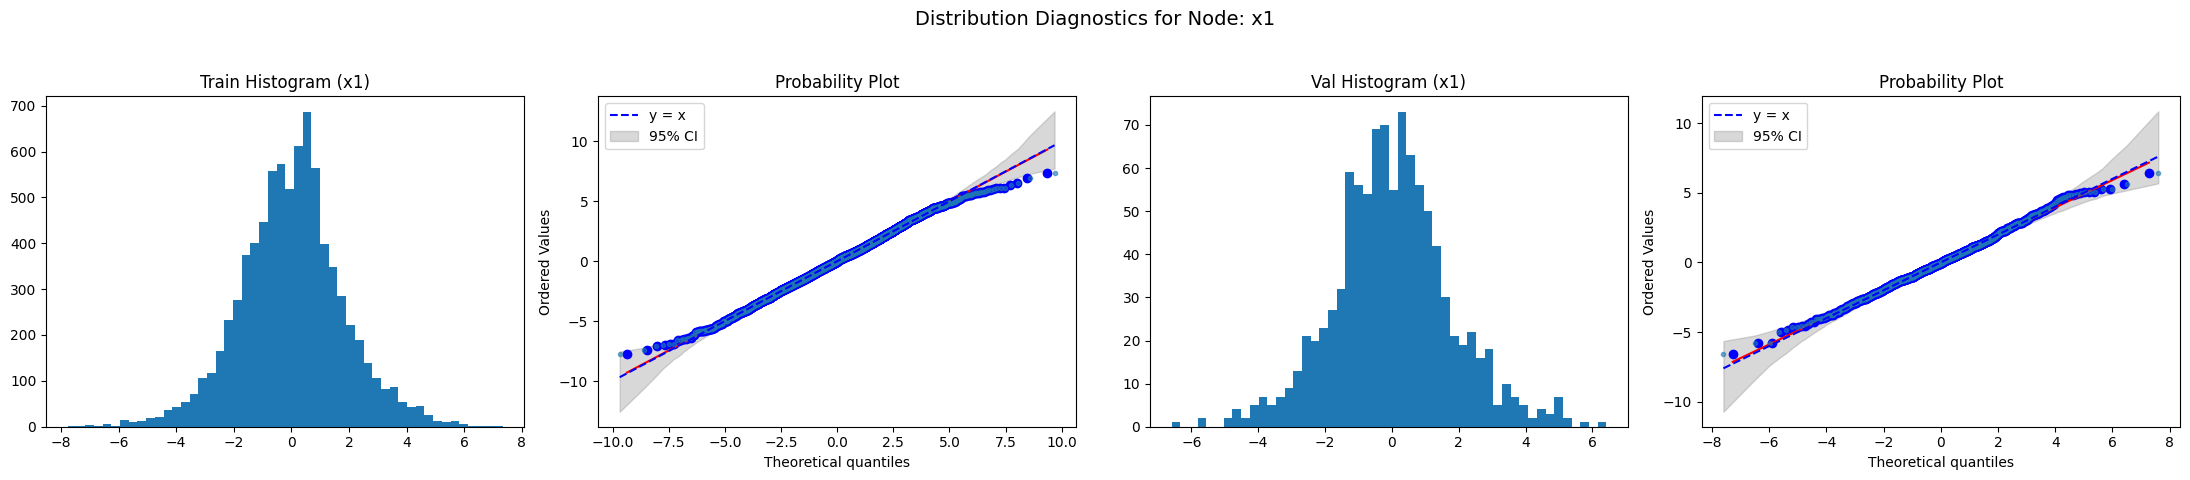


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


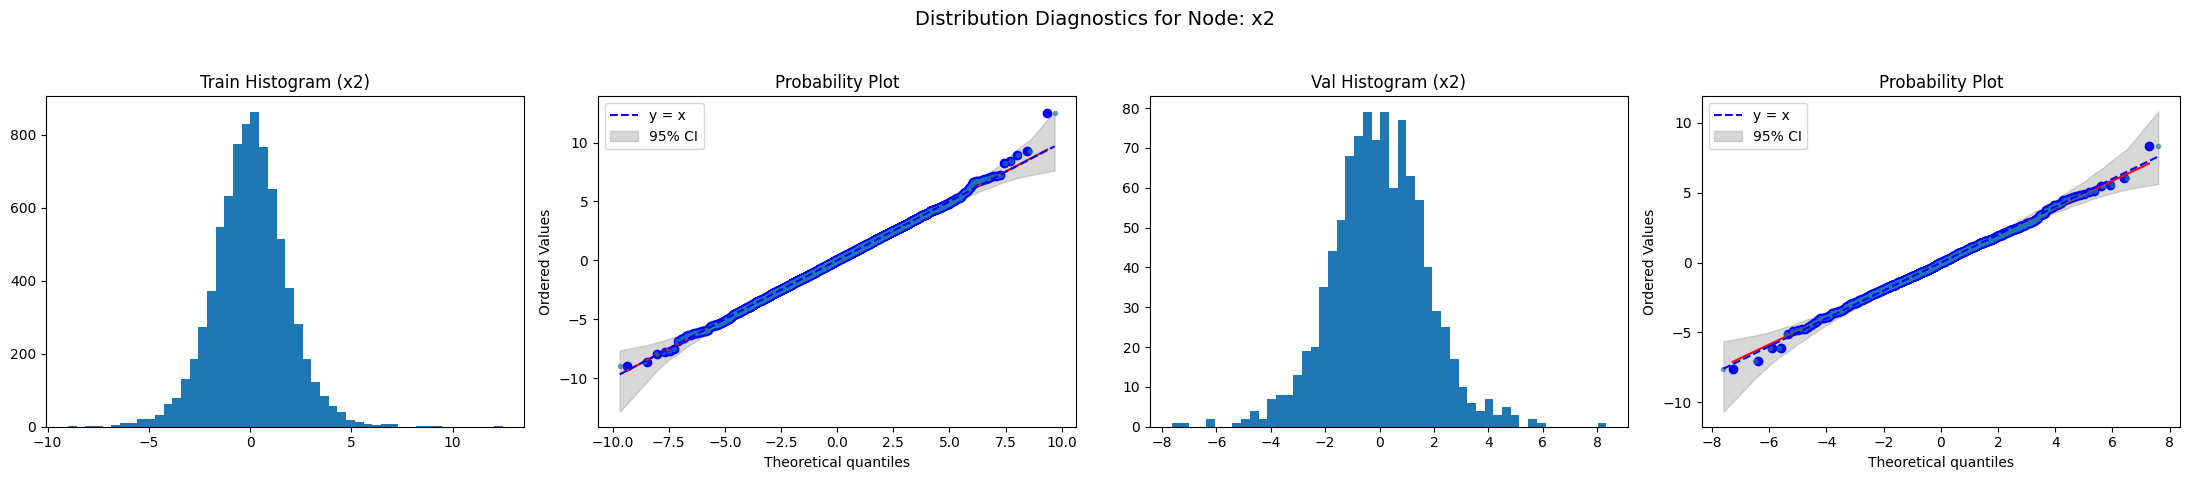


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


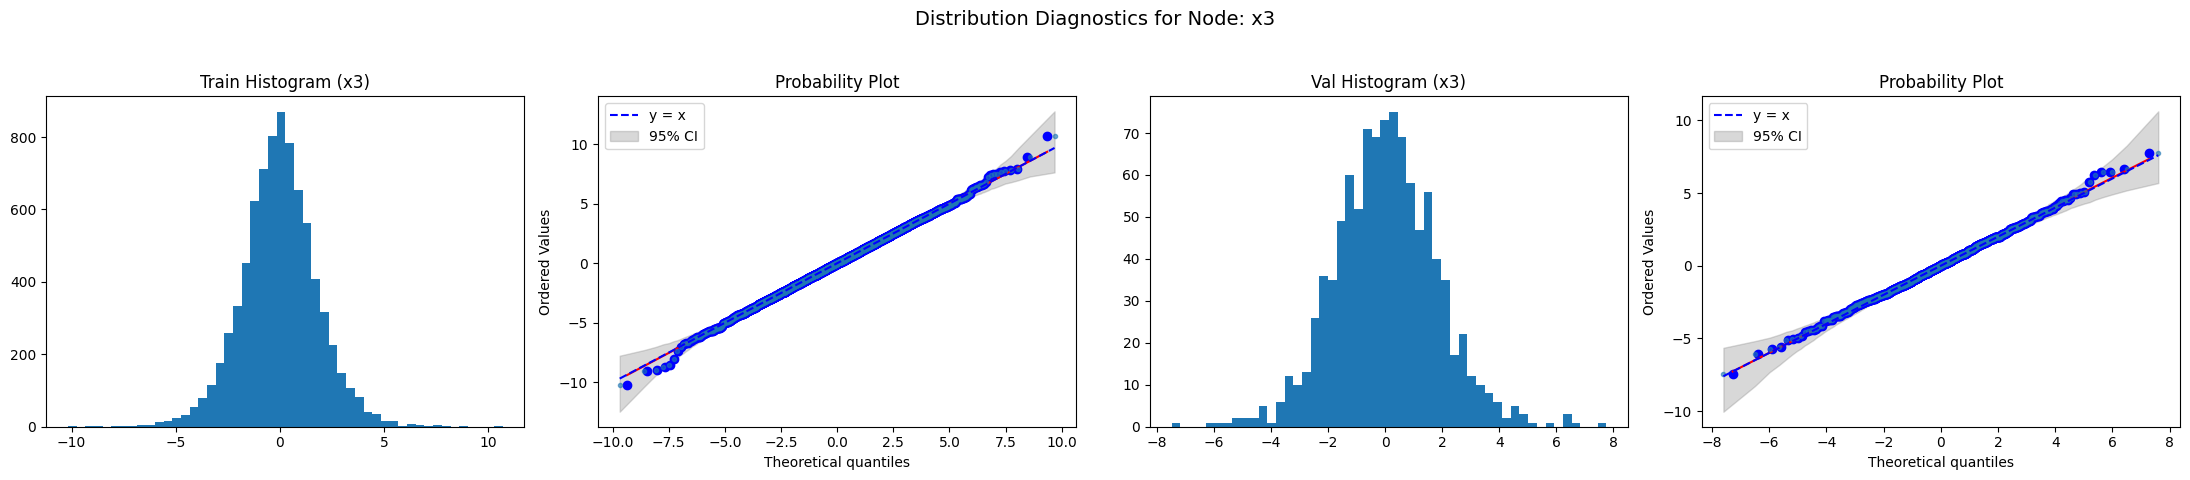

In [ ]:
inspect_trafo_standart_logistic(configuration_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficient estimates


----*----------*-------------*--------check LS of x1 ------------*-----------------*-------------------*--
Node type :source

----*----------*-------------*--------check LS of x2 ------------*-----------------*-------------------*--


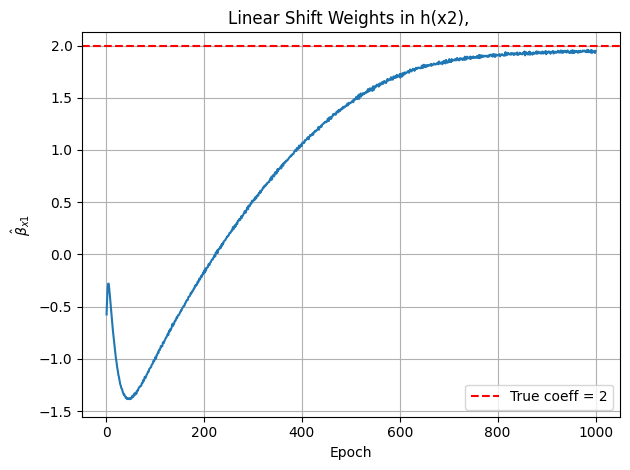


----*----------*-------------*--------check LS of x3 ------------*-----------------*-------------------*--


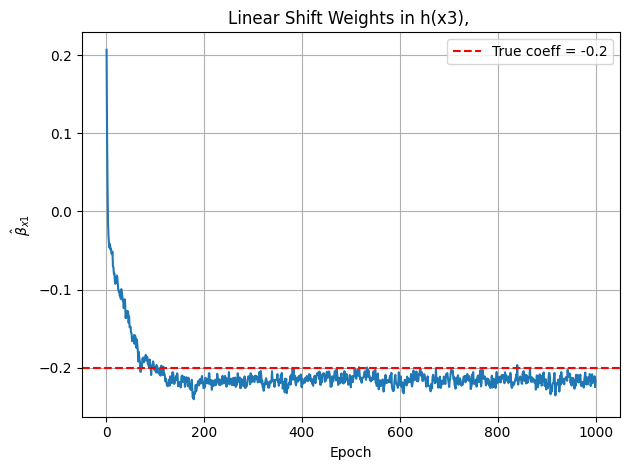

In [ ]:
# x1-> x2, x1-> x3, x2-> x3
true_coeffs = {'x2': [2],'x3': [-0.2, 0.3]}

for node in node_list:
    print(f'\n----*----------*-------------*--------check LS of {node} ------------*-----------------*-------------------*--')
    
    if node_list[node]['node_type'] == 'source':
        print(f"Node type :source")
        continue
    
    # Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    # Load saved shifts
    shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")
    with open(shift_path, 'r') as f:
        all_shift_weights = json.load(f)

    # Sort epochs numerically
    epochs = sorted(all_shift_weights.keys(), key=lambda x: int(x.split('_')[1]))

    # Number of shifts (incoming edges) for this node
    example_epoch = all_shift_weights[epochs[0]]
    num_shifts = len(example_epoch)

    # Plot per shift (incoming edge)
    for shifts_idx in range(num_shifts):
        shift_name = f"shift_{shifts_idx}"
        weights_over_time = []

        for epoch in epochs:
            weight_matrix = np.array(all_shift_weights[epoch][shift_name])  # shape: [out_features, in_features]
            avg_weight = weight_matrix.mean()
            weights_over_time.append(avg_weight)

        plt.figure()
        plt.plot(range(1, len(epochs) + 1), weights_over_time)

        # If this node has a true coefficient for this shift, draw a horizontal red line
        if node in true_coeffs:
            true_val = true_coeffs[node][shifts_idx]
            plt.axhline(y=true_val, color='r', linestyle='--', label=f"True coeff = {true_val}")
            plt.legend()

        plt.title(f"Linear Shift Weights in h({node}), ")
        plt.xlabel("Epoch")
        plt.ylabel(fr'$\hat{{\beta}}_{{{node_list[node]["parents"][shifts_idx]}}}$')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
Node type : source, not supported yet.

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--
Module 0 (LinearShift) weights:
tensor([[1.9511]], device='cuda:0')

----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--
Module 0 (ComplexShiftDefaultTabular) predictions:
Module 1 (LinearShift) weights:
tensor([[-0.2186]], device='cuda:0')


/tmp/ipykernel_622397/1953398127.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")


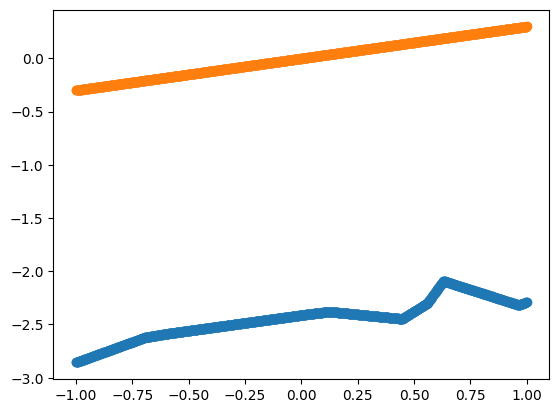

In [ ]:

verbose = False
batch_size = 4112

x = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (100, 1)


def f(x):
    return -0.3*x  

for node in node_list:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')

    if node_list[node]['node_type'] == 'source':
        print("Node type : source, not supported yet.")
        continue

    # Load model
    NODE_DIR = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")

    tram_model = get_fully_specified_tram_model(node, node_list, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()

    for i, module in enumerate(tram_model.nn_shift):
        module_name = module.__class__.__name__
        if module_name == 'LinearShift':
            print(f"Module {i} ({module_name}) weights:")
            print(module.fc.weight.data)
        else:
            print(f"Module {i} ({module_name}) predictions:")
            with torch.no_grad():
                y = module(x)
plt.scatter(x.cpu().numpy(),y.cpu().numpy())
plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")
plt.show()


# 7. Sample from Graph

In [ ]:
sample_full_dag(configuration_dict,
                EXPERIMENT_DIR,
                device,
                do_interventions={},
                number_of_samples= 10_000,
                batch_size = 32,
                delete_all_previously_sampled=True,
                verbose=True,
                debug=False)     

Directory does not exist: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x1/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x2/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x1/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x1: 100%|██████████| 10000/10000 [00:01<00:00, 5378.48it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 319.72it/s]
/home/bule/TramDag/utils/sampling_tram_data.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list.append(torch.tensor(tensor))  # ensure tensor type



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x2/sampling
-- sampled latents
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x2: 100%|██████████| 10000/10000 [00:02<00:00, 3334.94it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 319.37it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x3/sampling
-- sampled latents
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=32, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=32, out_features=32, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=32, out_features=1, bias=False)
    )
    (1): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x3: 100%|██████████| 10000/10000 [00:05<00:00, 1852.69it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 330.64it/s]


## 7.3 Inspect Sampling

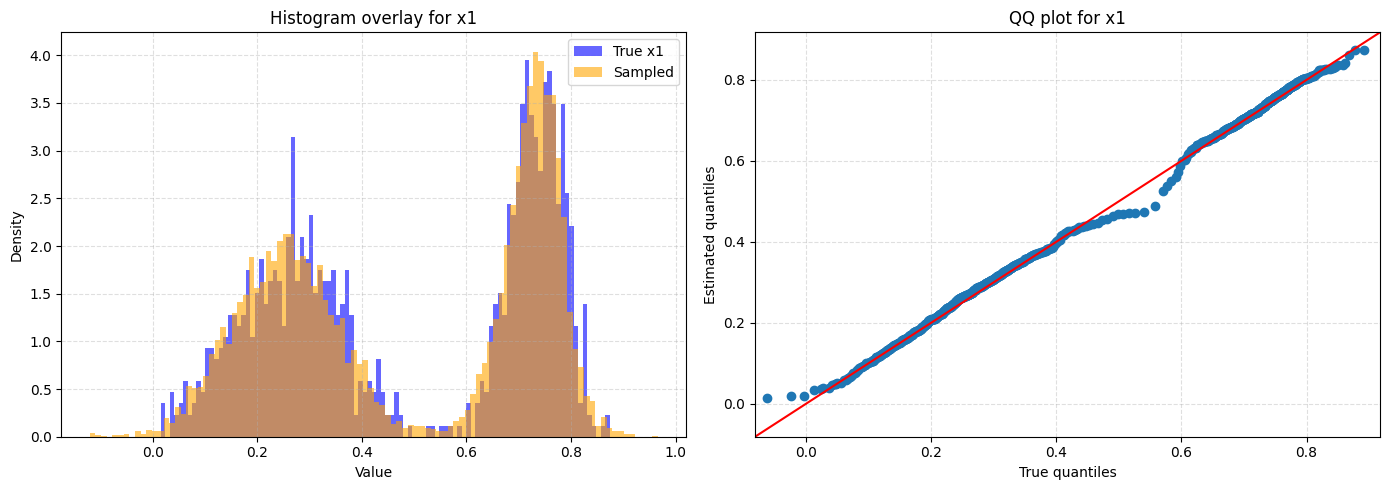

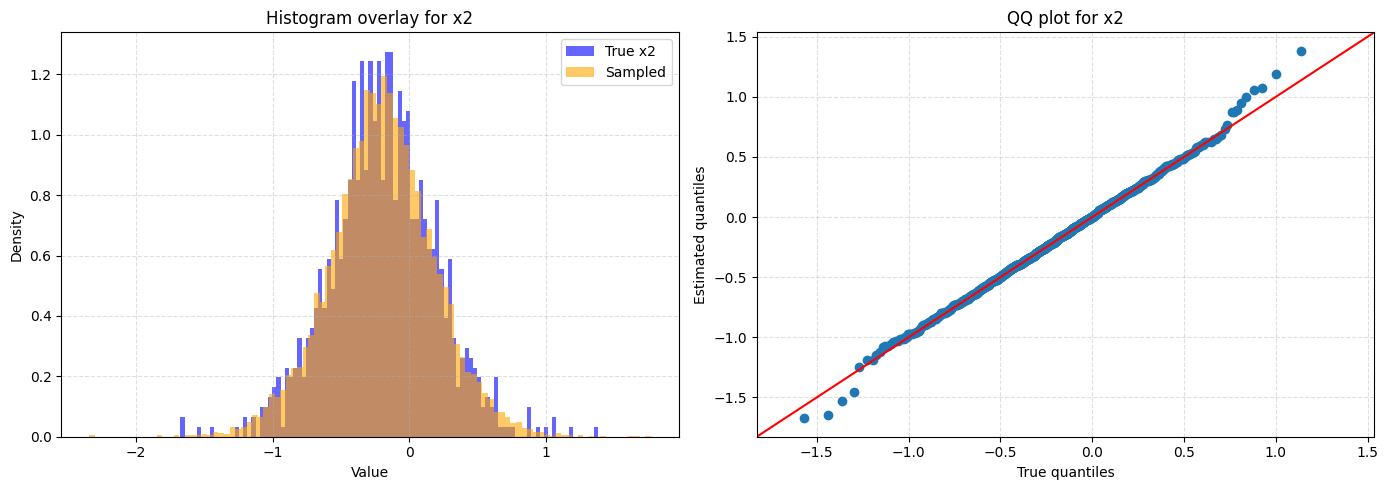

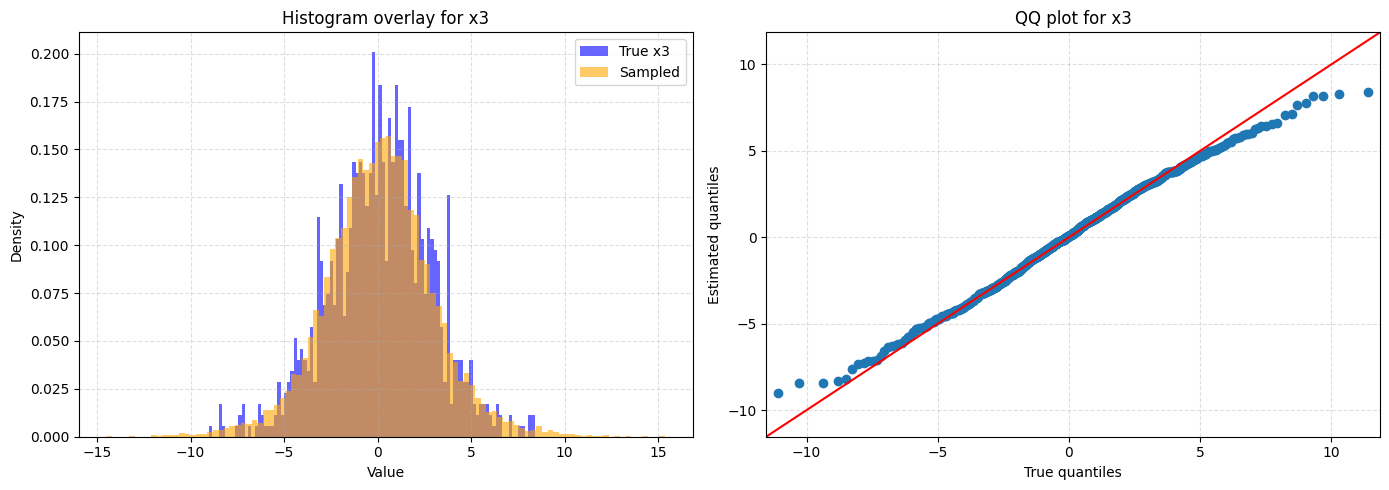

In [ ]:
show_samples_vs_true(test_df,node_list,EXPERIMENT_DIR)

## 7.4 Intervention

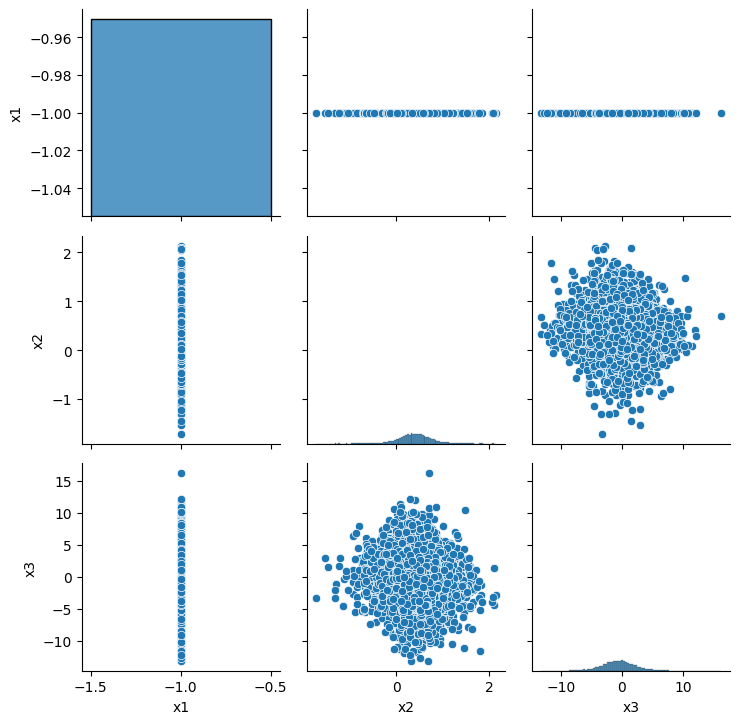

In [26]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag(configuration_dict,
                EXPERIMENT_DIR,
                device,
                do_interventions={'x1':-1.0},
                number_of_samples= 10_000,
                batch_size = 32,
                delete_all_previously_sampled=True,
                verbose=True,
                debug=False)  

/home/bule/TramDag/utils/sampling_tram_data.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list.append(torch.tensor(tensor))  # ensure tensor type


Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x1/sampling

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x2/sampling
-- sampled latents
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0):

h() for samples in  x2:   0%|          | 0/313 [00:00<?, ?it/s]

h() for samples in  x2: 100%|██████████| 313/313 [00:00<00:00, 1594.98it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 327.72it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_cs2/x3/sampling
-- sampled latents
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=32, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=32, out_features=32, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=32, out_features=1, bias=False)
    )
    (1): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x3: 100%|██████████| 313/313 [00:00<00:00, 1056.76it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 336.40it/s]


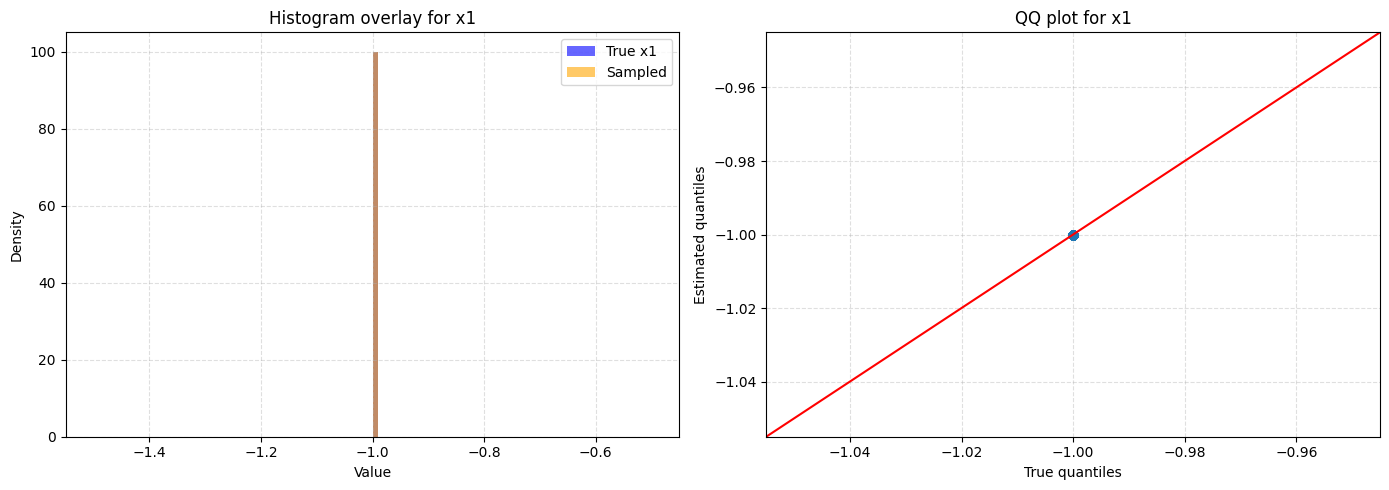

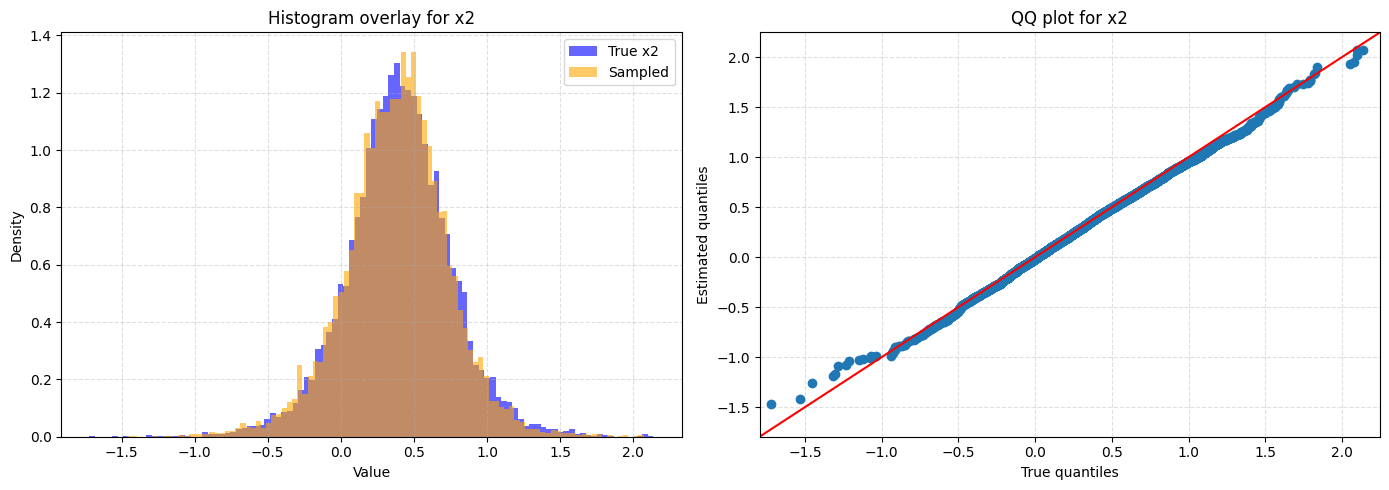

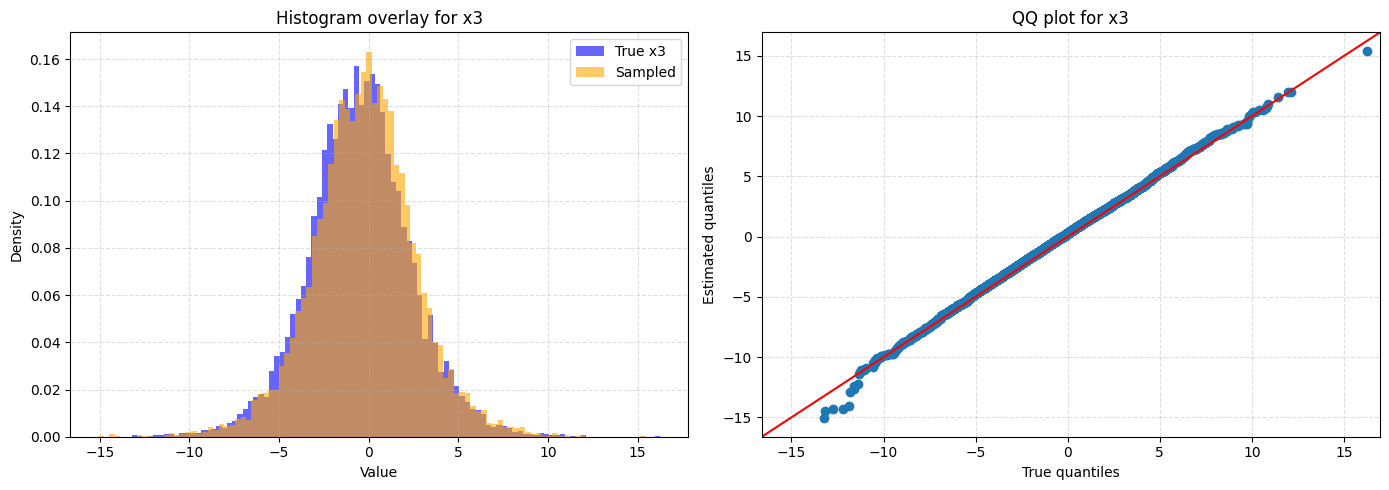

In [ ]:
show_samples_vs_true(test_df,node_list,EXPERIMENT_DIR)